In [1]:
# Importing the required libraries for the CBOW model
from keras.preprocessing import text
from tensorflow.keras.utils import to_categorical
from keras.preprocessing import sequence
from keras.utils import pad_sequences
import numpy as np
import pandas as pd

In [2]:
# Sample data for training the CBOW model
data = """Deep learning (also known as deep structured learning) is part of a broader family of machine learning methods based on artificial neural networks with representation learning. Learning can be supervised, semi-supervised or unsupervised.
Deep-learning architectures such as deep neural networks, deep belief networks, deep reinforcement learning, recurrent neural networks, convolutional neural networks and Transformers have been applied to fields including computer vision, speech recognition, natural language processing, machine translation, bioinformatics, drug design, medical image analysis, climate science, material inspection and board game programs, where they have produced results comparable to and in some cases surpassing human expert performance.
"""

# Split the text data into words
dl_data = data.split()

In [3]:
print(dl_data)

['Deep', 'learning', '(also', 'known', 'as', 'deep', 'structured', 'learning)', 'is', 'part', 'of', 'a', 'broader', 'family', 'of', 'machine', 'learning', 'methods', 'based', 'on', 'artificial', 'neural', 'networks', 'with', 'representation', 'learning.', 'Learning', 'can', 'be', 'supervised,', 'semi-supervised', 'or', 'unsupervised.', 'Deep-learning', 'architectures', 'such', 'as', 'deep', 'neural', 'networks,', 'deep', 'belief', 'networks,', 'deep', 'reinforcement', 'learning,', 'recurrent', 'neural', 'networks,', 'convolutional', 'neural', 'networks', 'and', 'Transformers', 'have', 'been', 'applied', 'to', 'fields', 'including', 'computer', 'vision,', 'speech', 'recognition,', 'natural', 'language', 'processing,', 'machine', 'translation,', 'bioinformatics,', 'drug', 'design,', 'medical', 'image', 'analysis,', 'climate', 'science,', 'material', 'inspection', 'and', 'board', 'game', 'programs,', 'where', 'they', 'have', 'produced', 'results', 'comparable', 'to', 'and', 'in', 'some', 

In [4]:
# Tokenization and vocabulary preparation
tokenizer = text.Tokenizer()
tokenizer.fit_on_texts(dl_data)  # Tokenize the words in your data
word2id = tokenizer.word_index  # Create a dictionary mapping words to unique IDs

# Add a special 'PAD' token with ID 0 for padding
word2id['PAD'] = 0
id2word = {v: k for k, v in word2id.items()}  # Create a reverse dictionary for mapping IDs to words

# Convert the words in your data to their corresponding IDs
wids = [[word2id[w] for w in text.text_to_word_sequence(doc)] for doc in dl_data]

# Get the vocabulary size, embedding size, and window size
vocab_size = len(word2id)
embed_size = 100
window_size = 2

# Print the vocabulary size and a sample of the word-to-ID mapping
print('Vocabulary Size:', vocab_size)
print('Vocabulary Sample:', list(word2id.items())[:10])

Vocabulary Size: 75
Vocabulary Sample: [('learning', 1), ('deep', 2), ('networks', 3), ('neural', 4), ('and', 5), ('as', 6), ('of', 7), ('machine', 8), ('supervised', 9), ('have', 10)]


In [5]:
# Function to generate (context word, target/label word) pairs
def generate_context_word_pairs(corpus, window_size, vocab_size):
    context_length = window_size * 2
    for words in corpus:
        sentence_length = len(words)
        for index, word in enumerate(words):
            context_words = []
            label_word = []
            start = index - window_size
            end = index + window_size + 1

            context_words.append([words[i] for i in range(start, end) if 0 <= i < sentence_length and i != index])
            label_word.append(word)

            x = pad_sequences(context_words, maxlen=context_length)  # Pad the context words
            y = to_categorical(label_word, vocab_size)  # Create a one-hot encoded label
            yield (x, y)

# Iterate through the generated (context, target) pairs
i = 0
for x, y in generate_context_word_pairs(corpus=wids, window_size=window_size, vocab_size=vocab_size):
    if 0 not in x[0]:
        # Uncomment the line below to print context and target words
        # print('Context (X):', [id2word[w] for w in x[0]], '-> Target (Y):', id2word[np.argwhere(y[0])[0][0]])

        if i == 10:
            break
        i += 1

In [6]:
# Import necessary libraries for building the model
import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense, Embedding, Lambda

# Create a Sequential model for CBOW
cbow = Sequential()

# Add an Embedding layer to convert word IDs to word vectors
cbow.add(Embedding(input_dim=vocab_size, output_dim=embed_size, input_length=window_size * 2))

# Add a Lambda layer to compute the mean of word vectors
cbow.add(Lambda(lambda x: K.mean(x, axis=1), output_shape=(embed_size,)))

# Add a Dense layer for the output with softmax activation
cbow.add(Dense(vocab_size, activation='softmax'))

# Compile the model with appropriate loss and optimizer
cbow.compile(loss='categorical_crossentropy', optimizer='rmsprop')

# Print a summary of the model's architecture
print(cbow.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 4, 100)            7500      
                                                                 
 lambda (Lambda)             (None, 100)               0         
                                                                 
 dense (Dense)               (None, 75)                7575      
                                                                 
Total params: 15075 (58.89 KB)
Trainable params: 15075 (58.89 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [7]:
# Training the CBOW model and storing loss values in a list
loss_values = []

for epoch in range(1, 6):
    loss = 0.
    i = 0

    # Iterate through the generated (context, target) pairs
    for x, y in generate_context_word_pairs(corpus=wids, window_size=window_size, vocab_size=vocab_size):
        i += 1
        loss += cbow.train_on_batch(x, y)  # Train the model on a batch

        # Print progress after processing a certain number of pairs
        if i % 100000 == 0:
            print('Processed {} (context, word) pairs'.format(i))
    loss_values.append(loss)
    # Print the loss at the end of each epoch
    print('Epoch:', epoch, '\tLoss:', loss)
    print()

Epoch: 1 	Loss: 433.6321630477905

Epoch: 2 	Loss: 429.3529932498932

Epoch: 3 	Loss: 426.25501465797424

Epoch: 4 	Loss: 423.2095785140991

Epoch: 5 	Loss: 420.6648395061493



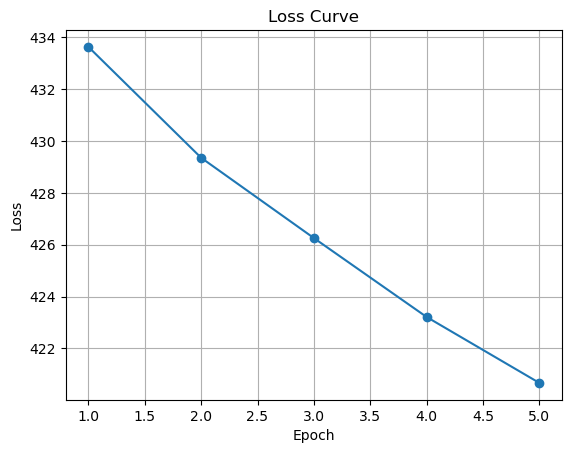

In [8]:
import matplotlib.pyplot as plt

# Create a list of epochs
epochs = range(1, len(loss_values) + 1)

# Plot the loss curve
plt.plot(epochs, loss_values, marker='o')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

In [9]:
# Get the word embedding weights from the trained CBOW model
weights = cbow.get_weights()[0]

# Exclude the first row, which corresponds to the 'PAD' token
weights = weights[1:]

# Print the shape of the word embedding weights
print(weights.shape)

# Create a DataFrame to display the word embeddings with word labels
word_embeddings_df = pd.DataFrame(weights, index=list(id2word.values())[1:])
word_embeddings_df.head()

(74, 100)


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
deep,0.005739,0.025781,-0.027626,0.032584,-0.015444,-0.027505,0.041894,0.056641,-0.017809,-0.003654,...,0.042867,0.017867,-0.036256,0.057751,-0.040862,-0.042978,-0.017873,-0.030481,-0.064871,-0.017290
networks,-0.029679,-0.031212,-0.059531,-0.010009,0.003809,-0.062140,-0.012975,0.041037,-0.019199,-0.035740,...,0.050795,-0.019556,-0.020374,0.009510,0.021349,0.012413,0.008800,-0.059738,0.025378,-0.005009
neural,-0.047497,-0.033008,0.023422,0.043261,-0.023662,0.012733,-0.022073,-0.033177,-0.008469,-0.049070,...,0.009073,0.023202,0.034181,0.023957,-0.000832,0.040245,-0.037643,-0.010673,-0.024790,-0.031705
and,-0.008325,-0.038029,0.041983,-0.005590,0.027060,-0.024579,0.008280,-0.016100,-0.015254,0.018695,...,-0.039387,0.028951,-0.026078,0.040126,-0.044525,-0.009593,0.035439,-0.008826,-0.017323,0.040908
as,-0.018923,-0.000892,0.002714,-0.003628,-0.019597,0.037494,0.004110,-0.034878,0.036167,-0.010094,...,0.014178,0.018415,-0.034193,-0.004891,-0.012376,-0.044148,0.000584,0.040901,0.046091,-0.022523


In [10]:
from sklearn.metrics.pairwise import euclidean_distances

distance_matrix = euclidean_distances(weights)
print(distance_matrix.shape)

similar_words = {search_term: [id2word[idx] for idx in distance_matrix[word2id[search_term]-1].argsort()[1:6]+1]
                   for search_term in ['deep']}

similar_words

(74, 74)


{'deep': ['methods', 'learning', 'speech', 'networks', 'science']}

In [11]:
# Calculate the Euclidean distances between word embeddings
from sklearn.metrics.pairwise import euclidean_distances
distance_matrix = euclidean_distances(weights)

# Print the shape of the distance matrix
print(distance_matrix.shape)

# Find similar words for a specific search term, e.g., 'deep'
similar_words = {
    search_term: [id2word[idx] for idx in distance_matrix[word2id[search_term] - 1].argsort()[1:6] + 1]
    for search_term in ['deep']
}

# Print the similar words for the search term
similar_words

(74, 74)


{'deep': ['methods', 'learning', 'speech', 'networks', 'science']}